In [45]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, color
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam

In [46]:
# Function to create U-Net model
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [47]:
# Function to apply Otsu's thresholding using skimage
def otsu_threshold_skimage(image):

    otsu_threshold = filters.threshold_otsu(image)
    otsu_binary = image > otsu_threshold

    return otsu_binary, otsu_threshold

In [48]:
# Function to predict U-Net output
def predict_with_unet(model, image):
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    return prediction[0, :, :, 0]  # Remove batch dimension and channel dimension

In [49]:
# Plotting function
def plot_results(grayscale, otsu_binary, otsu_threshold, unet_output):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Grayscale Image")
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Otsu's Thresholded Image\nThreshold = {otsu_threshold:.2f}")
    plt.imshow(otsu_binary, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("U-Net Output")
    plt.imshow(unet_output, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('output.png')
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


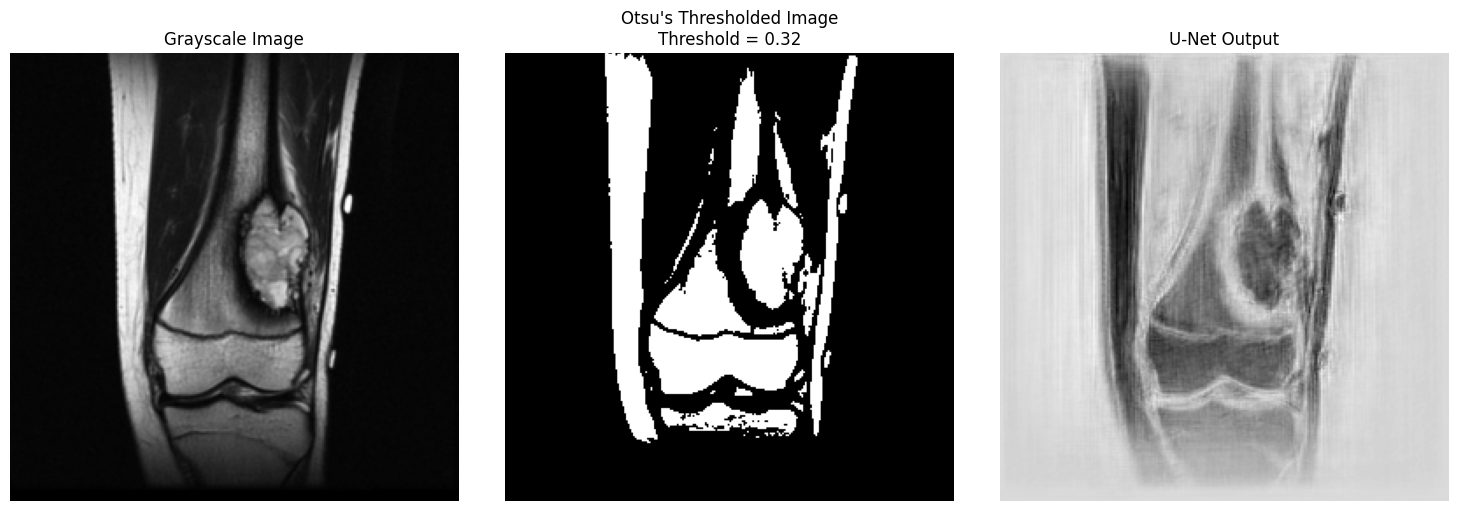

In [55]:
image = io.imread("legmri.jpg", as_gray=True)
image = resize(image, (256, 256), anti_aliasing=True)

model = unet(input_size=(256, 256, 1))
otsu_binary, otsu_threshold = otsu_threshold_skimage(image)

# Resize grayscale image to match U-Net input size if needed (using skimage.transform.resize)
from skimage.transform import resize

unet_output = predict_with_unet(model, image)
plot_results(image, otsu_binary, otsu_threshold, unet_output)